# **Model Development and Selection**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC

### Goals
1. Build and fit multiple classification models
2. Use GridSearch and Random Search to determine the best model parameters 
3. Compare metrics of each model to find the best model

I will build and compare the following models:
- Multinomial Naive Bayes
- Bagging Classifier
- Ada Boost Classifier
- Random Forest Classifier
- Extra Trees Classifier
- SVM Classifier

I will use a TF-IDF Vectorizer for pre-processing. The TF-IDF Vectorizer will split each post into individual words or tokens. The vectorizer creates a column for every word present in the dataset and the value of each column is the number of times that word or variable appears in the post. TF-IDF allows for multiple feature engineering/ pre-processing choices such as binarization and limitations on minimum frequency of words.

In [2]:
#First I read in the data
df = pd.read_csv('data/combined_dataset_no_short_posts.csv')

In [3]:
#I will be using the contents of the self-text (the posts) as my x-variable
X = df['self_text']

# I set y to be the subreddit which is the variable I am trying to predict
y= df['subreddit']

In [4]:
# Calculate the baseline accuracy
1 - y.mean()

0.2997568055228681

The baseline accuracy is the proportion of my dataset that comes from the camping subreddit. If I were to guess that a poster comes from the ultralight subreddit, I would be correct about 70% of the time. This is a barometer for how successful the models are compared with guessing pased on proportion.

In [4]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

I use a train-test split to create a training dataset to train the model and a validation dataset or test dataset to determine the model's success with unknown data.

### Multinomial Naive Bayes

In [27]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [28]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

In [32]:
pgrid = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [2, 3, 4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__binary': [False, True]
}

gs = GridSearchCV(pipe, pgrid, cv=10, n_jobs=2)

In [33]:
%%time
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

CPU times: total: 2.66 s
Wall time: 8min 56s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=2,
             param_grid={'tvec__binary': [False, True],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [34]:
gs.best_params_

{'tvec__binary': False,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [35]:
# Training Score
print(gs.score(X_train, y_train))
# Testing Score
print(gs.score(X_test, y_test))

0.9473849372384937
0.9303420144336366


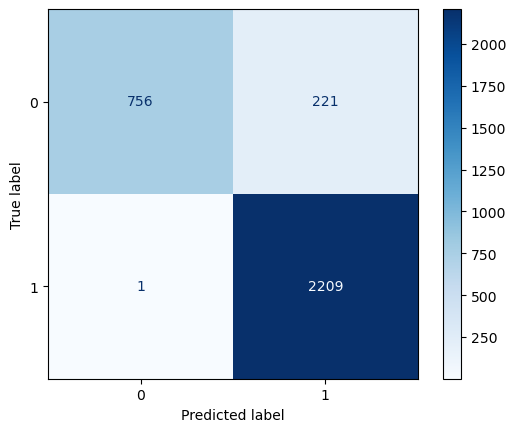

In [36]:
# Get predictions
preds = gs.predict(X_test)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues');

### Bagging Classifier with Decision Trees

In [66]:
# Instantiate the Decision Tree Classifier
tree = DecisionTreeClassifier()

# Define parameter distributions for TfidfVectorizer
tvec_param_dist = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [2, 3, 4],
    'tvec__binary': [False, True]
}

# Define parameter distributions for BaggingClassifier
bagging_param_dist = {
    'bag__base_estimator__max_depth': [None, 1, 2, 3, 4, 5, 6, 7],
    'bag__base_estimator__min_samples_leaf': np.arange(11, 22, 2)
}

# Combine the parameter distributions
param_dist = {**tvec_param_dist, **bagging_param_dist}

# Create a pipeline that includes TfidfVectorizer and BaggingClassifier
pipeline = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(estimator=tree, n_estimators=100, random_state=42))
])

# Specify the scoring metric (e.g., F1 score)
scoring_metric = 'f1'

# Create a RandomizedSearchCV object with the scoring parameter
rs = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_jobs=2, scoring=scoring_metric, random_state=42)


In [67]:
%%time
# Fit the grid search for each step
# Fit the grid search on your preprocessed and vectorized data
rs.fit(X_train, y_train)

C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


CPU times: total: 4min 41s
Wall time: 1h 1min 54s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('bag',
                                              BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                                n_estimators=100,
                                                                random_state=42))]),
                   n_jobs=2,
                   param_distributions={'bag__base_estimator__max_depth': [None,
                                                                           1, 2,
                                                                           3, 4,
                                                                           5, 6,
                                                                           7],
                                        'bag__base_estimator__min_samples_leaf': array([11, 13, 15, 17, 19, 21]),
                                        'tvec__binary': [False, True],
                                        'tvec__min_df': [2, 3, 4],
                                        'tvec__stop_words': [None, 'english']},
                   random_state=42, scoring='f1')

In [68]:
rs.best_params_

{'tvec__stop_words': 'english',
 'tvec__min_df': 4,
 'tvec__binary': False,
 'bag__base_estimator__min_samples_leaf': 15,
 'bag__base_estimator__max_depth': None}

The best parameters from this grid search for the TF-IDF Vectorizer were:
- including 'english' stop words
- Not binarizing
- tvec_min_df : 4

I will continue to tune parameters, however for the initial trial of other models, these are the parameters I will set for the TF-IDF Vectorizer to reduce computing time.

In [69]:
# Training Score
print(rs.score(X_train, y_train))
# Testing Score
print(rs.score(X_test, y_test))

0.9729491326080565
0.9676122403395131


*Initial thoughts: these are decent scores, but I believe there is significant room for improvement*

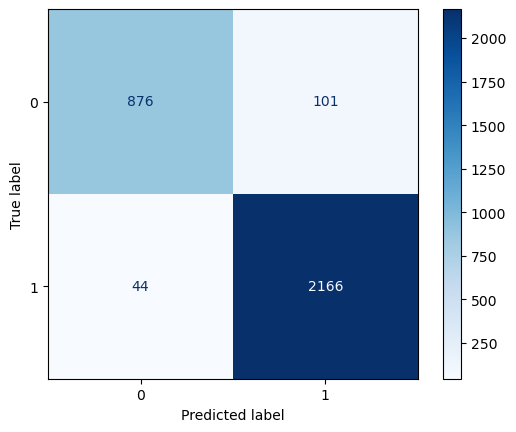

In [70]:
# Get predictions
preds = rs.predict(X_test)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Blues');

In [33]:
tvec = TfidfVectorizer(stop_words = "english", min_df=4)
X_train_transformed = tvec.fit_transform(X_train)
X_test_transformed = tvec.transform(X_test)

In [86]:
#Bagging Classifier with n_estimators =500

tree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=15)
bag = BaggingClassifier(estimator=tree, n_estimators=500, random_state=42)

In [87]:
bag.fit(X_train_transformed, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=15),
                  n_estimators=500, random_state=42)

In [88]:
bag.score(X_train_transformed, y_train)

0.9624476987447699

In [77]:
bag.score(X_test_transformed, y_test)

0.9416379039849389

### AdaBoost Model

In [35]:
#The AdaBoost model

ada =AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300
)


ada.fit(X_train_transformed, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300)

In [36]:
print(ada.score(X_train_transformed, y_train))
print(ada.score(X_test_transformed, y_test))


1.0
0.9943520552243489


This is a good accuracy score: 99.4%. This means that 1 out of every 200 posts are misclassified.

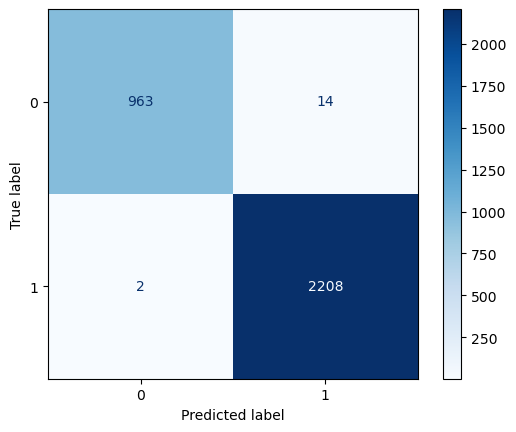

In [92]:
# Get predictions
ada_preds = ada.predict(X_test_transformed)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, ada_preds, cmap='Blues');

### Random Forest Model

In [61]:
#Random Forest Model
rf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    oob_score=True,
)

In [62]:
%%time
rf.fit(X_train_transformed, y_train)

CPU times: total: 40.7 s
Wall time: 1min 14s


RandomForestClassifier(n_estimators=500, oob_score=True)

In [64]:
print(rf.score(X_train_transformed, y_train))
print(rf.score(X_test_transformed, y_test))
print(rf.oob_score_)

1.0
0.9927831816755569
0.9927824267782427


In [ ]:
rf.feature_importances_

#Create a dataframe of the feature importances from Random Forest
feature_importances = pd.DataFrame({
    'variable': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
feature_importances.head(25)

### Extra Trees Model

In [49]:
# Extra Trees

et = ExtraTreesClassifier(n_estimators=500, random_state=42)
et.fit(X_train_transformed, y_train)

ExtraTreesClassifier(n_estimators=500, random_state=42)

In [50]:
print(et.score(X_train_transformed, y_train))
print(et.score(X_test_transformed, y_test))

1.0
0.9927831816755569


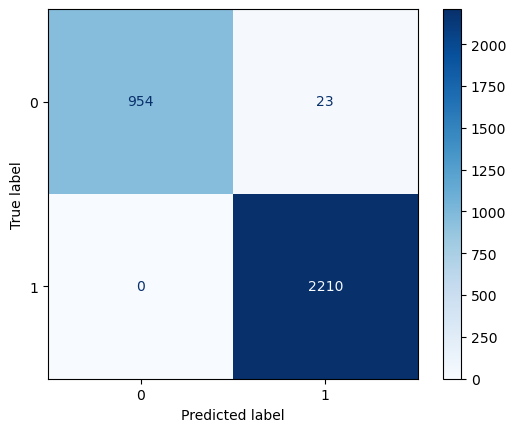

In [95]:
# Get predictions
et_preds = et.predict(X_test_transformed)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, et_preds, cmap='Blues');

In [59]:
feature_importances= et.feature_importances_

In [58]:
feature =tvec.get_feature_names_out()

In [54]:
X_train_df = pd.DataFrame(X_train_transformed)

In [60]:
feature_importance_df = pd.DataFrame({
    'feature': tvec.get_feature_names_out(),
    'importance': et.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_df.head(25)

,feature,importance
3007,camping,0.038415
6851,https,0.009212
14262,weight,0.008542
3534,com,0.008297
2997,camp,0.008024
3066,car,0.005231
13352,trail,0.004645
13607,ul,0.004459
2208,backpacking,0.004275
13626,ultralight,0.004187


In [7]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_transformed.toarray())
X_test_sc = sc.transform(X_test_transformed.toarray())

In [7]:
pgrid = {"C": np.linspace(0.0001, 1, 5)}

In [31]:
# Instantiate and fit a gridsearch model for this SVC!

svc = LinearSVC(C=.1, dual='auto', tol=.00001, max_iter=2000)

#kf = KFold(n_splits=5, shuffle=True, random_state=2023)

#gs = GridSearchCV(svc, pgrid, cv=kf, n_jobs=2)

In [32]:
%%time
svc.fit(X_train_sc, y_train)

CPU times: total: 7min 23s
Wall time: 12min 20s


C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.1, dual='auto', max_iter=2000, tol=1e-05)

In [30]:
svc.score(X_test_sc, y_test)

0.7267022278004392

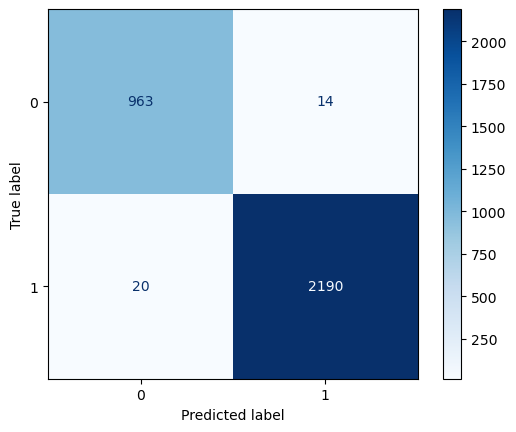

In [25]:
# Get predictions
svc_preds = svc.predict(X_test_sc)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, svc_preds, cmap='Blues');

In [ ]:
#The AdaBoost model
ada =AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300
)

et = ExtraTreesClassifier(n_estimators=500, random_state=42)

In [71]:
%%time
vc = VotingClassifier([
    ('ada', ada),
    ('et', et),
], voting='hard')

vc.fit(X_train_transformed, y_train)

CPU times: total: 1min 31s
Wall time: 2min 51s


VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                 n_estimators=300)),
                             ('et',
                              ExtraTreesClassifier(n_estimators=500,
                                                   random_state=42))])

In [72]:
print(vc.score(X_train_transformed, y_train))

print(vc.score(X_test_transformed, y_test))

1.0
0.996862252902416


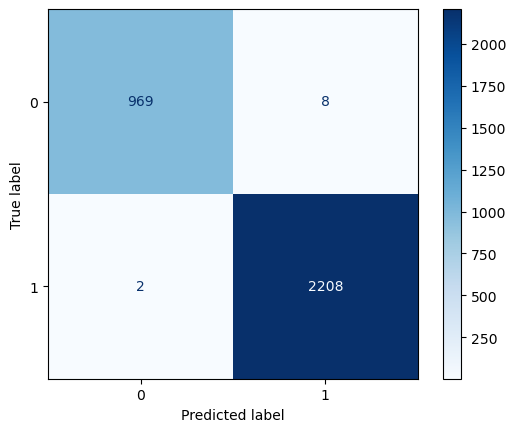

In [73]:
# Get predictions
vc_preds = vc.predict(X_test_transformed)

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, vc_preds, cmap='Blues');

# Examining the misclassified

In [100]:
mismatched_indices = (et_preds != y_test)
mismatched_texts = X_test[mismatched_indices]

for i, text in enumerate(mismatched_texts):
    predicted_label = et_preds[mismatched_indices][i]
    true_label = y_test.values[mismatched_indices][i]
    print(f"Predicted: {predicted_label} - Actual: {true_label}\n{text}\n")


Predicted: 1 - Actual: 0
https://www.reddit.com/r/campingwithkids/
Please contribute. If anyone wants to be a moderator, please join. 

Predicted: 1 - Actual: 0
https://www.reddit.com/r/CampingGear/comments/141twlo/should_rcampinggear_close_for_two_days_to_protest/

We are voting on this over at r/campinggear and the support is currently strongly in favor. 

Will the mods of r/camping support this for this subreddit?

Predicted: 1 - Actual: 0
I have a ton of hiking and camping experience. I've been to almost all state parks and a ton of the national forests. I don't, on the other hand, have much hunting experience. I don't really know where to begin with this, as far as where I should go or what I should bring. I have a decent amount of gear. But, I think, most of it is more applicable to 3-5 day trips. Less long term stuff. I would really love to go to Alaska, because it has the largest national forests, but it is pretty far from where I am, so I think I'd like to stay in the lower 48

### AdaBoost Model Misclassifications

In [101]:
mismatched_indices = (ada_preds != y_test)
mismatched_texts = X_test[mismatched_indices]

for i, text in enumerate(mismatched_texts):
    predicted_label = ada_preds[mismatched_indices][i]
    true_label = y_test.values[mismatched_indices][i]
    print(f"Predicted: {predicted_label} - Actual: {true_label}\n{text}\n")


Predicted: 0 - Actual: 1
With my mind all over the place lately with what's going on I needed to decompress. I cant hike, no trail running, fishing, bla bla bla  as all provincial parks are closed. I know there's worse things going on in the world than my little "cant hike"problems so what did I do? I gave 35 years of hiking/camping stuff away to the homeless shelter. It filled a full size van. 8 tents, 12 packs from kids to full expedition, 10 sleeping bags, sleeping pads, mats, coolers, nalgene bottles, stoves with fuel. You name it it was in there. Then I went into my closet. Bags of good clothes from socks to jackets.Every piece of cotton I own went in there plus every piece of technical clothing that I dont wear.  I feel better now. My mind and shop are decluttered and so people will get some much needed things.I reminisced and let go of many things not just gear. Here's a pick of my new go to gear closet. It's a hell of a lot lighter now. Thanks the whole point right?http://imgur

In [14]:
mismatched_indices = (svc_preds != y_test)
mismatched_texts = X_test[mismatched_indices]

for i, text in enumerate(mismatched_texts):
    predicted_label = svc_preds[mismatched_indices][i]
    true_label = y_test.values[mismatched_indices][i]
    print(f"Predicted: {predicted_label} - Actual: {true_label}\n{text}\n")


Predicted: 0 - Actual: 1
With my mind all over the place lately with what's going on I needed to decompress. I cant hike, no trail running, fishing, bla bla bla  as all provincial parks are closed. I know there's worse things going on in the world than my little "cant hike"problems so what did I do? I gave 35 years of hiking/camping stuff away to the homeless shelter. It filled a full size van. 8 tents, 12 packs from kids to full expedition, 10 sleeping bags, sleeping pads, mats, coolers, nalgene bottles, stoves with fuel. You name it it was in there. Then I went into my closet. Bags of good clothes from socks to jackets.Every piece of cotton I own went in there plus every piece of technical clothing that I dont wear.  I feel better now. My mind and shop are decluttered and so people will get some much needed things.I reminisced and let go of many things not just gear. Here's a pick of my new go to gear closet. It's a hell of a lot lighter now. Thanks the whole point right?http://imgur

### Voting Classifier misclassifications

In [47]:
mismatched_indices = (vc_preds != y_test)
mismatched_texts = X_test[mismatched_indices]

for i, text in enumerate(mismatched_texts):
    predicted_label = vc_preds[mismatched_indices][i]
    true_label = y_test.values[mismatched_indices][i]
    print(f"Predicted: {predicted_label} - Actual: {true_label}\n{text}\n")

Predicted: 0 - Actual: 1
With my mind all over the place lately with what's going on I needed to decompress. I cant hike, no trail running, fishing, bla bla bla  as all provincial parks are closed. I know there's worse things going on in the world than my little "cant hike"problems so what did I do? I gave 35 years of hiking/camping stuff away to the homeless shelter. It filled a full size van. 8 tents, 12 packs from kids to full expedition, 10 sleeping bags, sleeping pads, mats, coolers, nalgene bottles, stoves with fuel. You name it it was in there. Then I went into my closet. Bags of good clothes from socks to jackets.Every piece of cotton I own went in there plus every piece of technical clothing that I dont wear.  I feel better now. My mind and shop are decluttered and so people will get some much needed things.I reminisced and let go of many things not just gear. Here's a pick of my new go to gear closet. It's a hell of a lot lighter now. Thanks the whole point right?http://imgur